In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Training results

In [89]:
path_dict = {

    "regular_ppo": "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_regular_increased/no_mm/model_50000_may_25/",

    "regular_ppo_increased": "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_regular_increased_2/no_mm/model_50000_may_25/",

    "transfer_learning_ppo_lag_5": "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_transfer_policy_increased/model_lag_5_50000_may_25/",

    "transfer_learning_ppo_lag_1": "/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_transfer_policy_increased/model_lag_1_50000_may_25/",
}

In [90]:
# regular_ppo = pd.read_csv(r'C:\Users\aksen\RL in MM\2D-ABM-master\sb3_log\ppo_model_regular\progress.csv', sep=',')

# classifier_data_ppo = pd.read_csv('/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_classified_features_early_stop/progress.csv')

# transfer_learning_ppo_lag_5 = pd.read_csv(r'C:\Users\aksen\RL in MM\2D-ABM-master\sb3_log\ppo_model_transfer_learning_FE_3\progress.csv')

# transfer_learning_ppo_lag_1 = pd.read_csv(r'C:\Users\aksen\RL in MM\2D-ABM-master\sb3_log\ppo_model_transfer_learning_FE_lag1\progress.csv')

In [91]:
path_dict.keys()

dict_keys(['regular_ppo', 'regular_ppo_increased', 'transfer_learning_ppo_lag_5', 'transfer_learning_ppo_lag_1'])

In [92]:
agent_states = []
train_results = []
rewards = []

for path in path_dict.keys():
    if path_dict[path]:
        if path == 'regular_ppo':
            train_result = pd.read_csv(path_dict[path] + 'progress.csv', sep=',')[2000:]
            print('ok')
        else:
            train_result = pd.read_csv(path_dict[path] + 'progress.csv', sep=',')
        
        
        if path == 'regular_ppo_increased':
            agent_state = pd.read_csv(path_dict[path] + 'agent_states.csv', sep=',')[50000:].reset_index(drop=True)
            print('ok')
        else:
            agent_state = pd.read_csv(path_dict[path] + 'agent_states.csv', sep=',')
        
        
        reward = pd.read_csv(path_dict[path] + 'rewards_df.csv', sep=',')
        
        agent_states.append(agent_state)
        train_results.append(train_result)
        rewards.append(reward)

ok
ok


In [93]:
train_results[1].shape

(2000, 14)

In [94]:
filtered_agent_states = []

for ag_state in agent_states:
    ag_state['index_250'] = ag_state['Unnamed: 0'].apply(lambda x: (x + 1) % 250 == 0)
    
    filtered_agent_states.append(ag_state[ag_state['index_250'] == 1])

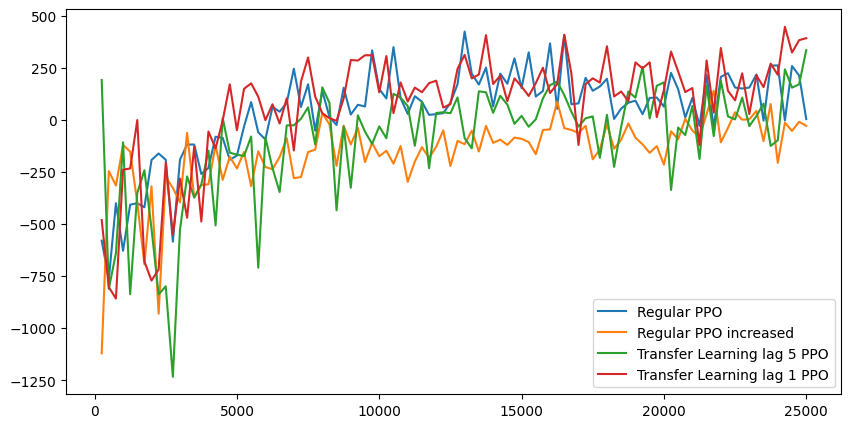

In [95]:
fig, ax = plt.subplots(figsize=[10, 5])
names = ['Regular PPO', 'Regular PPO increased', 'Transfer Learning lag 5 PPO', 'Transfer Learning lag 1 PPO']

for i in range(4):
    ag_state = filtered_agent_states[i]
    name = names[i]
    ax.plot(ag_state['equity'][:100], label=name)
    
ax.legend()
plt.show();

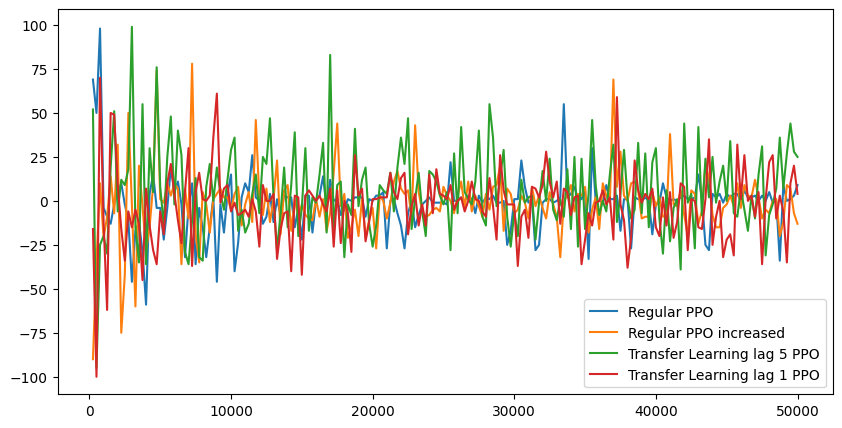

In [96]:
fig, ax = plt.subplots(figsize=[10, 5])
names = ['Regular PPO', 'Regular PPO increased', 'Transfer Learning lag 5 PPO', 'Transfer Learning lag 1 PPO']

for i in range(4):
    ag_state = filtered_agent_states[i]
    name = names[i]
    ax.plot(ag_state['assets'], label=name)
    
ax.legend()
plt.show();

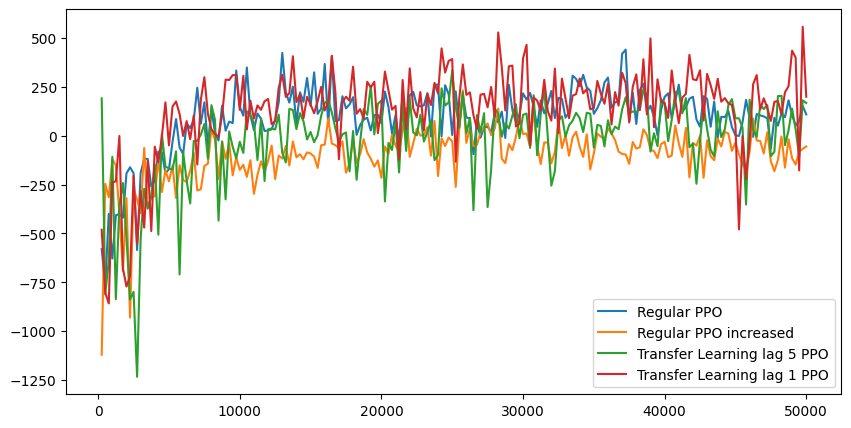

In [97]:
fig, ax = plt.subplots(figsize=[10, 5])
names = ['Regular PPO', 'Regular PPO increased', 'Transfer Learning lag 5 PPO', 'Transfer Learning lag 1 PPO']

for i in range(4):
    ag_state = filtered_agent_states[i]
    name = names[i]
    ax.plot(ag_state['equity'], label=name)
    
ax.legend()
plt.show();

# Testing model performances

## Importing models

In [98]:
import gymnasium as gym
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from tqdm import tqdm

from typing import Type, List

from AgentBasedModel.exchange import ExchangeAgent, Asset
from AgentBasedModel.traders import (
    Trader,
    Universalist,
    Chartist1D,
    Chartist2D,
    Fundamentalist,
    SingleTrader,
)
from AgentBasedModel.extra import Event
from AgentBasedModel.utils.math import mean, std, rolling

import random
from tqdm import tqdm

from AgentBasedModel import *
from AgentBasedModel.extra import *
from AgentBasedModel.visualization import *
from AgentBasedModel.visualization.other import plot_book
from AgentBasedModel.visualization.other import plot_full_book
from AgentBasedModel.visualization.trader import *
from random import randint

import torch
from torch import nn
from torch.utils.data import DataLoader

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [99]:
run utils_nikita//functions.ipynb

In [100]:
class SimpleModel(nn.Module):
    def __init__(self):
        
        super(SimpleModel, self).__init__()
        
        self.linear = nn.Linear(16, 30)
        self.linear2 = nn.Linear(30, 20)
        self.linear3 = nn.Linear(20, 10)
        self.linear4 = nn.Linear(10, 3)
        
#         self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        x = self.softmax(x)
        
        return x

    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

feature_extractor_path = 'models/simple_model_shift_1_no_lob_25_may'
# feature_extractor_path = 'models/simple_model_shift_5_no_lob_25_may'
    
simple_model = SimpleModel()
simple_model.load_state_dict(torch.load('models/simple_model_shift_1_no_lob_25_may'))
    
class customFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, downloading_path='models/simple_model_shift_1_no_lob_25_may', observation_space = None):
        
        super(customFeatureExtractor, self).__init__(observation_space = observation_space, features_dim=11)
        
        self.base = simple_model
#         print(self.base.load_state_dict(torch.load(downloading_path)))
        
        for param in self.base.parameters():
            param.requires_grad = False
            
        self.base.linear4 = nn.Linear(10, 10)
        
        self.base.softmax = Identity()
        
#         self.features_dim = 11
        self.observation_space = observation_space
    
    def forward(self, x):
        
        if len(x.size()) == 1:
#             print(x, x[-1])
#             print(x.size())

            features = torch.Tensor(x[:-1]).to('cuda')
            inventory = torch.Tensor([x[-1]]).to('cuda')

            features = self.base(features)

            x = torch.cat([features, inventory])
            
            return x.unsqueeze(0)
            
        else:
            
            features = [x[i][:-1].unsqueeze(0) for i in range(x.size()[0])]
            inventory = [[x[i][-1]] for i in range(x.size()[0])]
            
            features = torch.cat(features, dim=0).to('cuda')
            inventory = torch.Tensor(inventory).to('cuda')

            features = self.base(features)
    
            correct_data = []

            for i in range(features.size()[0]):
                correct_data.append(torch.cat([features[i], inventory[i]]).unsqueeze(0))

            x = torch.cat(correct_data, dim=0)
        
            return x.to('cuda')

# training gym

In [101]:
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan, SubprocVecEnv

In [102]:
class RLTrader(SingleTrader):
    def __init__(
            self,
            market: ExchangeAgent,
            timing=1,
            cash:   float | int = 1**3, #10**3,
            assets: int = 0,
            limit_inventory=100
        ):
        """
        :param market: link to exchange agent
        :param cash: trader's cash available, defaults 10**3
        :param assets: trader's number of shares hold, defaults 0
        :param access: number of future dividends known, defaults 0 (knows only current dividend)
        """
        super().__init__(market, cash, assets)
        self.type = 'RLTrader'
        
        self.timing = timing
        self.limit_inventory = limit_inventory
        self.last_move = 0
        
        self.last_cash = self.cash
        self.last_assets = self.assets
        
        self.last_qty_bid = 0
        self.last_qty_ask = 0
        
        self.last_price_ask = 0
        self.last_price_bid = 0
    
    def call(self, action): # bid, ask qty. bid, ask price

        self.last_cash = self.cash
        self.last_assets = self.assets
        
        bid_price = self.market.order_book['bid'].to_list()[0]['price']
        ask_price = self.market.order_book['ask'].to_list()[0]['price']
        
        bid_qty_action = action[0] * 10
        ask_qty_action = action[1] * 10
        
        bid_price_action = action[2]
        ask_price_action = action[3]
        
        ask_price = ask_price + (bid_price_action - 5) * 0.1
        bid_price = bid_price - (ask_price_action - 5) * 0.1
        
        if self.last_move % self.timing == 0:
            
            if self.orders:
                for i in range(len(self.orders)):
                    order = self.orders[0]
                    self._cancel_order(order)
                    
            
            # Restriction on the inventory
            if ask_qty_action - self.assets > self.limit_inventory:
                ask_qty_action = self.limit_inventory + self.assets
            
            if bid_qty_action + self.assets > self.limit_inventory:
                bid_qty_action = self.limit_inventory - self.assets
            
            
            if self.assets >= -1 * self.limit_inventory and ask_qty_action > 0:
                self._sell_limit(ask_qty_action, ask_price)
            
            if self.assets <= self.limit_inventory and bid_qty_action > 0:
                self._buy_limit(bid_qty_action, bid_price)
            
            self.last_qty_ask = ask_qty_action
            self.last_qty_bid = bid_qty_action
            
            self.last_price_ask = ask_price
            self.last_price_bid = bid_price
            
#             print('ask', ask_qty_action, ask_price)
#             print('bid', bid_qty_action, bid_price)
            
        self.last_move += 1

In [103]:
class Simulator_gym(gym.Env):
    """
    Simulator is responsible for launching agents' actions and executing scenarios
    """
    # todo: Only traders are to be passed, trader -> trader.exchange -> trader.exchange.asset. Use dict comprehension to get unique items.
    def __init__(
            self,
            assets:    List[Type[Asset]],
            exchanges: List[ExchangeAgent],
            traders:   List[Type[Trader]],
            events:    List[Type[Event]] = None,
            
            observation_space = None,
            action_space = None,
        
            random_seed = None,
            
            SGU = None,
            device = 'cuda'
        ):
        
        super(Simulator_gym, self).__init__()
        
        self.assets = assets
        self.exchanges = exchanges
        self.traders = traders
        self.events = [event.link(self) for event in events] if events else None  # link all events to simulator

        self.info = SimulatorInfo(exchanges, traders)
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.random_seed = random_seed
        self.device = device
        
        self.RL_agent = None
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        self.SGU = SGU
        
    def get_reward(self):
        if not self.RL_agent:
            return 0
        
        current_ask_qty = 0
        current_bid_qty = 0
        
        current_ask_price = 0
        current_bid_price = 0
        
        for i in range(len(self.RL_agent.orders)):
            
            order = self.RL_agent.orders[i]
            
            if order.order_type == 'ask':
                current_ask_qty = order.qty
                
            elif order.order_type == 'bid':
                current_bid_qty = order.qty
                
        current_ask_price = self.RL_agent.last_price_ask
        current_bid_price = self.RL_agent.last_price_bid
        
        executed_asks = self.RL_agent.last_qty_ask - current_ask_qty
        executed_bids = self.RL_agent.last_qty_bid - current_bid_qty
        
        reward = min(executed_asks, executed_bids) * (current_ask_price - current_bid_price) / 5
        reward = reward - (abs(self.RL_agent.last_assets - (executed_asks - executed_bids)) / (self.RL_agent.limit_inventory))
        
        # [200.5, 20, 90, 201.4, 0],
        
        rewards_container.append([reward, executed_asks, executed_bids, current_ask_price, current_bid_price])
        
        agent_states_container.append([self.RL_agent.assets, self.RL_agent.cash, self.RL_agent.equity()])
        
        return reward
        
        
#         delta_cash = self.RL_agent.cash - self.RL_agent.last_cash
#         delta_assets = self.RL_agent.assets - self.RL_agent.last_assets

#         return delta_cash - abs(self.RL_agent.last_assets + delta_assets)/self.RL_agent.limit_inventory
            
#             return delta_cash - 0.1 * (self.RL_agent.assets + delta_assets)
#             return (self.RL_agent.cash + self.RL_agent.assets * self.exchanges[0].price()) - 10**3 - abs(self.RL_agent.assets)
        

    def simulate(self, n_iter: int, silent: bool = False) -> object:
        
        for it in tqdm(range(n_iter), desc='Simulation', disable=silent):
            
            # Call scenario
            if self.events:
                for event in self.events:
                    event.call(it)

            # Capture current info
            self.info.capture()

            # Call Traders
            random.shuffle(self.traders)
            

            for trader in self.traders:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    trader.change_sentiment(self.info)
                if type(trader) == RLTrader:
                    continue

                trader.call()    # trader's action
            
            # Pay Traders
            for trader in self.traders:
                trader.income()  # trader's dividend and interest

            # Update assets
            for asset in self.assets:
                asset.update()  # generate next dividend
        
            for exchange in self.exchanges:
                exchange.transactions.iteration += 1
        
        return self
    
    def reset(self, seed=None, options=None):
        
        self.random_seed += 1001
        
        market_agents=[40, 40, 40, 1]
        dividend = 10
        risk_free_rate = 0.05
        price = 200
        
        random.seed(self.random_seed)

        assets = [Stock(dividend)]

        simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)

        simple_traders = [
            *[Random(simple_exchange) for _ in range(market_agents[0])],
            *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
            *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
            *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
            *[RLTrader(simple_exchange)]
        ]
        
        self.assets = assets
        self.exchanges = [simple_exchange]
        self.traders = simple_traders
        self.events = None
        
        self.info = SimulatorInfo(self.exchanges, self.traders)
        
        self.called_traders = set()
        self.initial_call = 0
        
        self.RL_agent = None
        
        self.simulate(1, silent=False)
        print('reset')
        
        self.FC = FeatureCollector(self.info, self.exchanges[0])
        
        features = self.FC.get_features()
        
        if self.SGU:
            features = torch.Tensor(features.values).to(self.device)
            signals = self.SGU(features)
            observations = np.array(signals.detach().to('cpu'), dtype='float32')

        else:
            features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
            observations = np.array(features.values[0], dtype='float32')
                        
        observations = np.append(observations, np.float32(0))
        
        reward = self.get_reward()
        terminated = False
        truncated = False
        info = dict()
        
#         print(observations)
        return observations, info
        
        
    def step(self, action):
        
        if self.initial_call == 0:
            self.simulate(1, silent=False)
        
        if self.initial_call == 1:
            trader = self.RL_agent
            trader.call(action)
            self.called_traders.add(trader)
        
        self.initial_call = 1
        
        for trader in self.traders:
            if trader in self.called_traders:
                pass
            
            else:
                if type(trader) == Universalist:
                    trader.change_strategy(self.info)
                if type(trader) in (Universalist, Chartist1D, Chartist2D):
                    try:
                        trader.change_sentiment(self.info)
                    except:
                        pass
                if type(trader) == RLTrader:
                    
                    self.RL_agent = trader
                    
                    features = self.FC.get_features()
                    
                    if self.SGU:
                        features = torch.Tensor(features.values).to(self.device)
                        signals = self.SGU(features)
                        observations = np.array(signals.detach().to('cpu'), dtype='float32')
                    
                    else:
                        features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                        observations = np.array(features.values[0], dtype='float32')
                        
                    observations = np.append(observations, np.float32(self.RL_agent.assets))

                    reward = self.get_reward()
                    
                    terminated = False
                    truncated = False
                    info = dict()
                    
#                     print(observations)
                    return observations, reward, terminated, truncated, info

                trader.call()
        
        # Finish cycle
        # Pay Traders
        for trader in self.traders:
            if type(trader) == RLTrader:
                continue
            else:
                trader.income()  # trader's dividend and interest

        # Update assets
        for asset in self.assets:
            asset.update()  # generate next dividend

        for exchange in self.exchanges:
            exchange.transactions.iteration += 1
        
        # Start new cycle
        
        # Call scenario
        if self.events:
            for event in self.events:
                event.call(it)

        # Capture current info
        self.info.capture()

        # Call Traders
        random.shuffle(self.traders)
        
        self.called_traders = set()
        
        for trader in self.traders:
            if type(trader) == Universalist:
                trader.change_strategy(self.info)
            if type(trader) in (Universalist, Chartist1D, Chartist2D):
                try:
                    trader.change_sentiment(self.info)
                except:
                    pass
            if type(trader) == RLTrader:
                
                self.RL_agent = trader
                
                features = self.FC.get_features()
                    
                if self.SGU:
                    features = torch.Tensor(features.values).to(self.device)
                    signals = self.SGU(features)
                    observations = np.array(signals.detach().to('cpu'), dtype='float32')

                else:
                    features['all_transaction_volume_1'] = (features['all_transaction_volume_1'] - 53.86) / (15.48 * 10)
                    observations = np.array(features.values[0], dtype='float32')

                observations = np.append(observations, np.float32(self.RL_agent.assets))
                    
                reward = self.get_reward()
                terminated = False
                truncated = False
                info = dict()
                
#                 print(observations)
                return observations, reward, terminated, truncated, info

            trader.call()    # trader's action
            self.called_traders.add(trader)

In [104]:
def make_env(seed=5024, no_mm = True, SGU=None):
    
    if no_mm:
        market_agents=[40, 40, 40, 0]
    else:
        market_agents=[40, 40, 40, 1]
    
    random_state = seed
    dividend = 10
    risk_free_rate = 0.05
    price = 200

    # gym settings

    # observation space
    if SGU:
        obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)
    else:
        obs_space = gym.spaces.Box(-1, 1, shape=(17,), seed=random_state)

    # action space
    action_space = gym.spaces.MultiDiscrete(np.array([10, 10, 16, 16]), seed=random_state) # bid, ask qty. bid, ask price
    
    random.seed(random_state)

    assets = [Stock(dividend)]

    simple_exchange = ExchangeAgent(assets[0], risk_free_rate, mean=price)
    
    simple_traders = [
    *[Random(simple_exchange) for _ in range(market_agents[0])],
    *[Chartist1D(simple_exchange) for _ in range(market_agents[1])],
    *[Fundamentalist(simple_exchange) for _ in range(market_agents[2])],
    *[MarketMaker1D(simple_exchange) for _ in range(market_agents[3])],
    *[RLTrader(simple_exchange)]
    ]
    
    
#     settings = {
#         'assets': [assets[0]],
#         'exchanges': [simple_exchange],
#         'traders': simple_traders, 

#         'observation_space': obs_space,
#         'action_space': action_space,
#         'random_seed': random_state,
#     }

    my_gym = Simulator_gym(**{
        'assets': [assets[0]],
        'exchanges': [simple_exchange],
        'traders': simple_traders}, 

        observation_space = obs_space,
        action_space = action_space,
        random_seed = random_state,
        SGU=SGU,
        )
    
    return my_gym
#     return settings

In [105]:
my_env = DummyVecEnv([make_env])

In [106]:
test_environment = make_env(no_mm = True)

In [107]:
agent_states_container = []
rewards_container = []

In [108]:
policy_kwargs = dict(
#     features_extractor_class=customFeatureExtractor,
#     net_arch=dict(pi=[64, 64], vf=[64, 64]),
)

# model = PPO("MlpPolicy", my_env, n_steps=25, verbose=1, batch_size=25)

In [109]:
model = PPO.load(path_dict['transfer_learning_ppo_lag_5'] + 'model_10000', my_env)

C:\WORKING_APPS\Anaconda_v2\envs\RL_MM_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
# model = ppo.load(path_dict['regular_ppo_increased'] + 'model_40000')
# model.load(path_dict['regular_ppo'] + 'model_40000')

In [111]:
first_features, info = test_environment.reset()

first_action = model.predict(first_features)

Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.15it/s]


reset


In [112]:
# model2.policy

In [113]:
first_action

(array([2, 6, 4, 6], dtype=int64), None)

In [114]:
from tqdm import trange

In [115]:
test_environment = make_env(no_mm = True)
type(test_environment.traders[-1])

__main__.RLTrader

In [116]:
def test_model(model, seed):
    test_environment = make_env(seed = seed, no_mm = True)
    
    first_features, info = test_environment.reset()

    action = model.predict(first_features)
    
    RL_agent = 0
    
    for trader in test_environment.traders:
#         print(type(trader))
        if type(trader) == RLTrader:
            RL_agent = trader
            break

    rewards = []
    assets_container = []
    rewards_container = []
    equity_list = []

    for i in range(250):

        features, reward, _, _, info = test_environment.step(action)

        rewards.append(reward)
        equity_list.append(RL_agent.equity())
        assets_container.append(int(RL_agent.assets))
        
        action = model.predict(features, deterministic=True)[0]
        
    return rewards, equity_list, assets_container

In [117]:
r, e, a = test_model(model, seed=3)

Simulation: 100%|██████████| 1/1 [00:00<00:00, 334.37it/s]


reset


Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.14it/s]


Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 115.17it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 114.91it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 216.79it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 157.40it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 60.17it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 216.64it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.20it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.09it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 207.23it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 246.14it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 331.23it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 104.51it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 150.99it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 103.75it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.25it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 166.13it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.77it/s]


reset



100%|██████████| 20/20 [04:41<00:00, 14.05s/it]


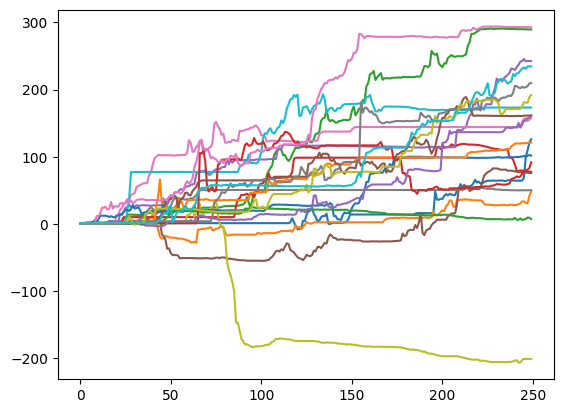

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.34it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 180.94it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 281.86it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 176.67it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.69it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 119.91it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 121.35it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.52it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 83.04it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 95.92it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 183.30it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 104.29it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.14it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 87.11it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 170.61it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.62it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.40it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 143.24it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


reset



100%|██████████| 20/20 [06:00<00:00, 18.01s/it]


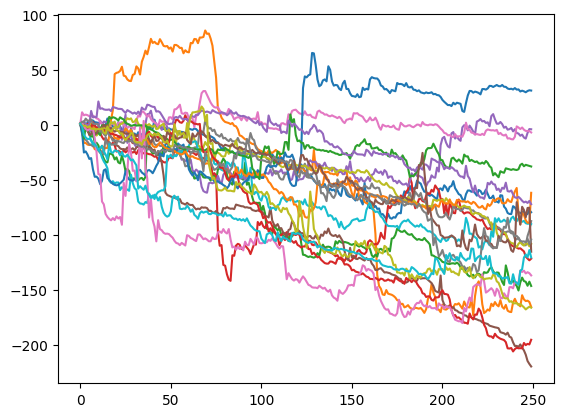

Simulation: 100%|██████████| 1/1 [00:00<00:00, 86.82it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 100.26it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.50it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 91.89it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.38it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.32it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 148.29it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.15it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 113.60it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.65it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.68it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.57it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.36it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.32it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.51it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 91.17it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 149.95it/s]


reset



100%|██████████| 20/20 [05:19<00:00, 15.97s/it]


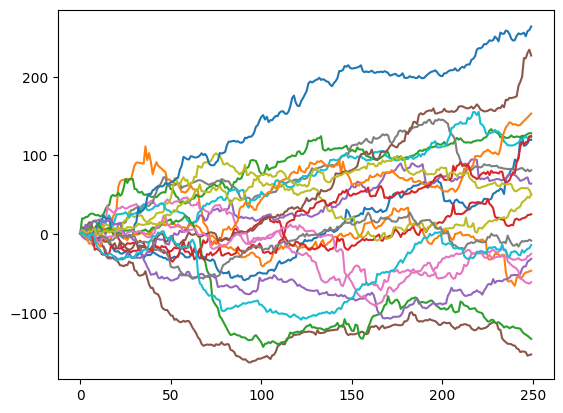

Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 115.16it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 94.08it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 164.81it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.45it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 147.49it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 103.59it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 131.48it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 249.85it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.53it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 250.78it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 111.42it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 104.26it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 200.40it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 125.32it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 130.75it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 159.37it/s]


reset



Simulation: 100%|██████████| 1/1 [00:00<00:00, 167.09it/s]


reset



100%|██████████| 20/20 [05:07<00:00, 15.38s/it]


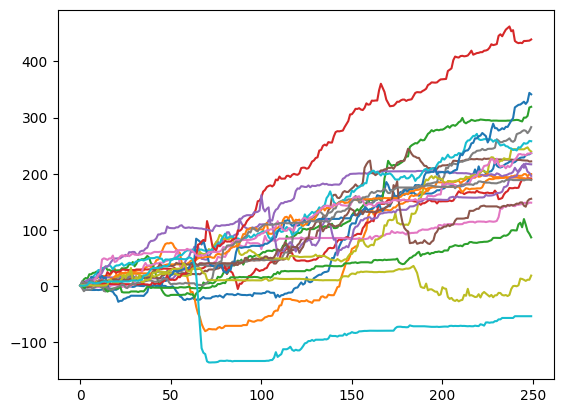

In [119]:
capturing_index=[5000, 10000, 20000, 40000]
# capturing_index=[20000]

models_performance = {}
# models_performance_2 = {}

# for key in path_dict.keys():

models_performance_200 = {}

for key in path_dict.keys():

    for number_of_iterations in capturing_index:
        model = PPO.load(path_dict[key] + f'model_{number_of_iterations}', my_env)
#         model = PPO.load("/Users/aksen/RL in MM/2D-ABM-master/sb3_log/ppo_model_regular_increased_2/no_mm/model_50000_may_25/" + f'model_{number_of_iterations}', my_env)
        
    
        seed = 10000

        random.seed(seed)
        
        rewards_30 = []
        equity_30 = []
        assets_30 = []
        
#         print(key + f"{number_of_iterations}")
    
        for i in trange(20):
            seed = seed + 1000

            rewards, equity_list, assets_container = test_model(model, seed)

            rewards_30.append(rewards)
            equity_30.append(equity_list)
            assets_30.append(assets_container)
        
        for i in range(20):
            equity_list = equity_30[i]

            plt.plot(equity_list)

        plt.show()
        
        models_performance[key + f" {number_of_iterations}_rewards"] = rewards_30
        models_performance[key + f" {number_of_iterations}_equity"] = equity_30
        models_performance[key + f" {number_of_iterations}_assets"] = assets_30
    
    
# model = PPO.load(path_dict['transfer_learning_ppo_lag_5'] + 'model_10000', my_env)

# random.seed(10000)

# rewards_100 = []
# equity_100 = []

# seed = 10000

# for i in trange(10):
#     seed = seed + 1000
#     rewards, equity_list, agent = test_model(model, seed)
    
#     rewards_100.append(rewards)
#     equity_100.append(equity_list)

In [338]:
agent_states = pd.DataFrame(agent_states_container, columns = ['assets', 'cash', 'equity'])
rewards_df = pd.DataFrame(rewards_container, columns=['reward', 'executed_asks', 'executed_bids', 'current_ask_price', 'current_bid_price'])

130.6900000000009 242.6024999999998 48.80249999999887


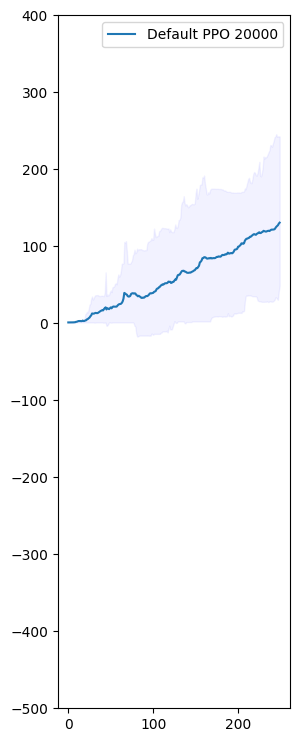

-100.11500000000159 -6.697500000007722 -165.7975000000033


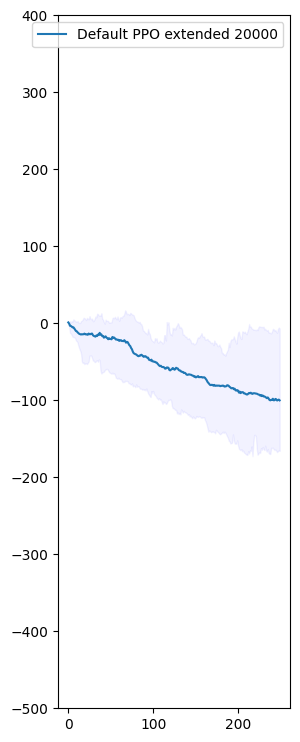

47.01249999999661 153.30249999999342 -61.09750000000213


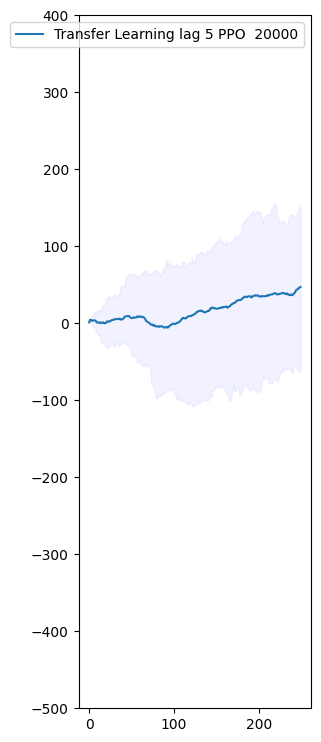

205.7725000000004 319.20249999999857 86.90250000000106


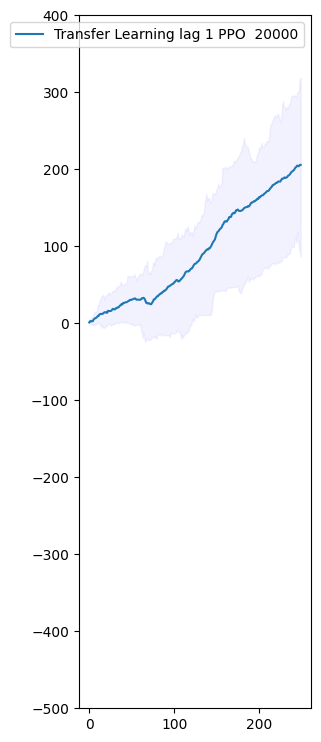

In [120]:
for key in path_dict.keys():
# for key in [0]:
    
    equity_3 = []
    labels = []
    
    for indx in capturing_index:
        equity_1 = models_performance[key + f' {indx}_equity']
        
        equity_2 = []
        for rew in equity_1:
            equity_2.append(pd.DataFrame(rew, columns=['equity']))
        
        equity_3.append(equity_2)
        
        if key == 'regular_ppo':
            labels.append('Default PPO' + f' {indx}')
        
        elif key == 'regular_ppo_increased':
            labels.append('Default PPO extended' + f' {indx}')
        
        elif key == 'transfer_learning_ppo_lag_1_increased':
            labels.append('Transfer Learning lag 1 Extended PPO ' + f' {indx}')
        
        elif key == 'transfer_learning_ppo_lag_5_increased':
            labels.append('Transfer Learning lag 5 Extended PPO ' + f' {indx}')
        
        elif key == 'transfer_learning_ppo_lag_1':
            labels.append('Transfer Learning lag 1 PPO ' + f' {indx}')
        
        elif key == 'transfer_learning_ppo_lag_5':
            labels.append('Transfer Learning lag 5 PPO ' + f' {indx}')
        
        else:
            labels.append(key + f' {indx}')
        
    draw_many_mean_quantile(equity_3, variable='equity', title=labels, quantile=0.1, figsize=[3, 9], y_lim=[-500, 400]) #, labels=labels);

In [411]:
model10 = PPO.load(path_dict['transfer_learning_ppo_lag_5'] + f'model_{40000}', my_env)

In [412]:
model10.policy

ActorCriticPolicy(
  (features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_features=30, out_features=20, bias=True)
      (linear3): Linear(in_features=20, out_features=10, bias=True)
      (linear4): Linear(in_features=10, out_features=10, bias=True)
      (softmax): Identity()
      (relu): ReLU()
    )
  )
  (pi_features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_features=30, out_features=20, bias=True)
      (linear3): Linear(in_features=20, out_features=10, bias=True)
      (linear4): Linear(in_features=10, out_features=10, bias=True)
      (softmax): Identity()
      (relu): ReLU()
    )
  )
  (vf_features_extractor): customFeatureExtractor(
    (base): SimpleModel(
      (linear): Linear(in_features=16, out_features=30, bias=True)
      (linear2): Linear(in_fe

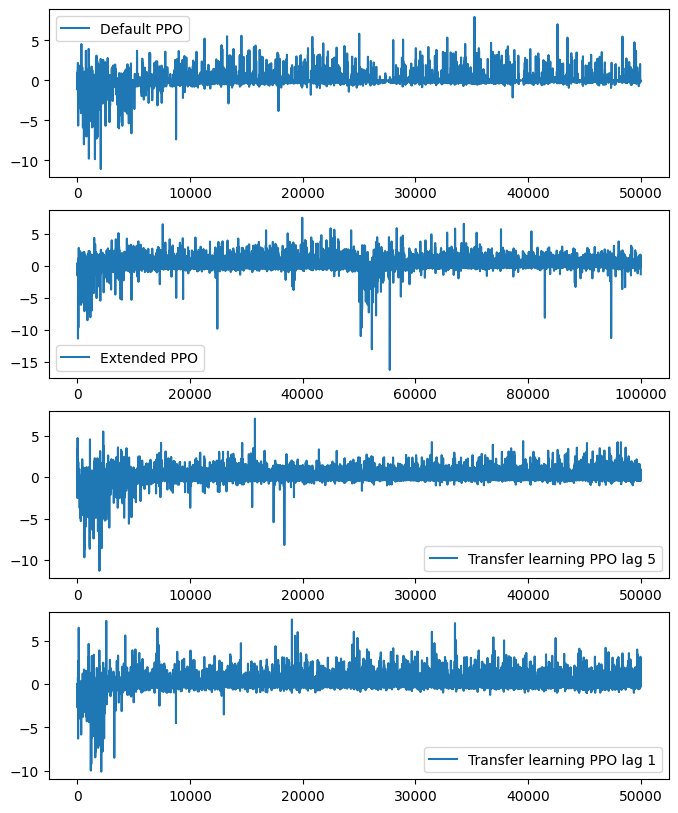

In [128]:
fig, ax = plt.subplots(4, figsize=[8, 10])
names = ["Default PPO", "Extended PPO",
#         "Transfer learning extended PPO lag 5", 
#         "Transfer learning extended PPO lag 1",
        "Transfer learning PPO lag 5",
        "Transfer learning PPO lag 1"]

j = 0
for key in path_dict.keys():
    rewards = pd.read_csv(path_dict[key] + 'rewards_df.csv')
    
    if key not in ['transfer_learning_ppo_lag_5_increased', 'transfer_learning_ppo_lag_1_increased']:
        ax[j].plot(rewards['reward'], label = names[j])
        ax[j].legend()
        j += 1
    
plt.legend()